<a href="https://colab.research.google.com/github/HieuVuong001/AQI_analysis/blob/main/ProjectCode_CMPE255.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Library

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import folium
from folium.plugins import HeatMap
from google.cloud import bigquery
from google.colab import auth
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Provide your Google Cloud credentials to the runtime

In [31]:
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [32]:
%load_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

Declare the Cloud project ID which will be used throughout this notebook

In [33]:
project_id = 'cmpe255-project-419122'

In [34]:
!gcloud config list

[component_manager]
disable_update_check = True
[core]
account = kwanqing.ong@sjsu.edu
project = cmpe255-project-419122

Your active configuration is: [default]


In [35]:
#!gcloud config set compute/region us-central1
#!gcloud config set compute/zone us-central1-a
!gcloud config list project

[core]
project = cmpe255-project-419122

Your active configuration is: [default]


In [36]:
!gcloud config set project 'cmpe255-project-419122'

Updated property [core/project].


In [37]:
!gcloud config list project

[core]
project = cmpe255-project-419122

Your active configuration is: [default]


In [38]:
# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'cmpe255-project-419122'
client = bigquery.Client(project=project_id)

#Print your current data
for dataset in client.list_datasets():
  print(dataset.dataset_id)

aqi_trend_analysis_dataset


## AQI Trend Analysis Dataset


## Data Processing

In [149]:
# Path to the directory where all your CSV files are stored
csv_directory = '/content/'

# List to hold data from each CSV
dataframes_list = []

# Loop through all the CSV files in the directory
for filename in os.listdir(csv_directory):
    if filename.endswith('.csv'):
        # Construct the full file path
        filepath = os.path.join(csv_directory, filename)
        # Read the CSV file and append it to the list
        df = pd.read_csv(filepath)
        dataframes_list.append(df)

# Concatenate all DataFrames in the list into one
annual_aqi_by_county_df = pd.concat(dataframes_list, ignore_index=True)

# Optionally, you can save the merged DataFrame to a new CSV file
annual_aqi_by_county_df.to_csv('/content/annual_aqi_by_county.csv', index=False)

# Display the shape of the merged DataFrame to confirm
print(f"Merged DataFrame shape: {annual_aqi_by_county_df.shape}")

annual_aqi_by_county_df.head()

In [109]:
annual_aqi_by_county_df = pd.read_csv('/content/annual_aqi_by_county.csv')
annual_aqi_by_county_df.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2016,279,247,32,0,0,0,0,87,51,37,0,0,221,58,0
1,Alabama,Clay,2016,116,109,7,0,0,0,0,56,45,30,0,0,0,116,0
2,Alabama,Colbert,2016,282,258,23,1,0,0,0,115,50,38,0,0,219,63,0
3,Alabama,DeKalb,2016,348,304,43,1,0,0,0,119,54,40,0,0,321,27,0
4,Alabama,Elmore,2016,117,107,10,0,0,0,0,77,48,40,0,0,117,0,0


In [110]:
# Rename columns to comply with BigQuery's column naming conventions
annual_aqi_by_county_df = annual_aqi_by_county_df.rename(columns={
    'Days PM2.5': 'Days_PM2_5',
})
annual_aqi_by_county_df.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
0,Alabama,Baldwin,2016,279,247,32,0,0,0,0,87,51,37,0,0,221,58,0
1,Alabama,Clay,2016,116,109,7,0,0,0,0,56,45,30,0,0,0,116,0
2,Alabama,Colbert,2016,282,258,23,1,0,0,0,115,50,38,0,0,219,63,0
3,Alabama,DeKalb,2016,348,304,43,1,0,0,0,119,54,40,0,0,321,27,0
4,Alabama,Elmore,2016,117,107,10,0,0,0,0,77,48,40,0,0,117,0,0


In [111]:
# Replacing spaces with underscores in column names
annual_aqi_by_county_df.columns = annual_aqi_by_county_df.columns.str.replace(' ', '_')
annual_aqi_by_county_df.columns

Index(['State', 'County', 'Year', 'Days_with_AQI', 'Good_Days',
       'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days',
       'Unhealthy_Days', 'Very_Unhealthy_Days', 'Hazardous_Days', 'Max_AQI',
       '90th_Percentile_AQI', 'Median_AQI', 'Days_CO', 'Days_NO2',
       'Days_Ozone', 'Days_PM2_5', 'Days_PM10'],
      dtype='object')

In [112]:
# Check the dataframe again with new column names
annual_aqi_by_county_df.head()

,State,County,Year,Days_with_AQI,Good_Days,Moderate_Days,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Max_AQI,90th_Percentile_AQI,Median_AQI,Days_CO,Days_NO2,Days_Ozone,Days_PM2_5,Days_PM10
0,Alabama,Baldwin,2016,279,247,32,0,0,0,0,87,51,37,0,0,221,58,0
1,Alabama,Clay,2016,116,109,7,0,0,0,0,56,45,30,0,0,0,116,0
2,Alabama,Colbert,2016,282,258,23,1,0,0,0,115,50,38,0,0,219,63,0
3,Alabama,DeKalb,2016,348,304,43,1,0,0,0,119,54,40,0,0,321,27,0
4,Alabama,Elmore,2016,117,107,10,0,0,0,0,77,48,40,0,0,117,0,0


In [113]:
# Save preprocessed data to big query
annual_aqi_by_county_df.to_gbq(
    'cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df',
    project_id='cmpe255-project-419122',
    if_exists='replace',
    progress_bar=True
)

100%|██████████| 1/1 [00:00<00:00, 3782.06it/s]


## Exploratory Data Analysis (EDA)

In [10]:
sql = """
SELECT
    *
FROM
    `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
ORDER BY
  Year, State, County
"""
dfquery = client.query(sql)

In [11]:
annual_aqi_by_county_df=dfquery.to_dataframe()
annual_aqi_by_county_df.head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
0,Alabama,Baldwin,2013,273,235,38,0,0,0,0,87,54,36,0,0,200,73,0
1,Alabama,Clay,2013,118,100,18,0,0,0,0,65,52,32,0,0,0,118,0
2,Alabama,Colbert,2013,285,252,33,0,0,0,0,80,51,38,0,0,202,83,0
3,Alabama,DeKalb,2013,360,319,41,0,0,0,0,93,52,38,0,0,305,55,0
4,Alabama,Elmore,2013,244,229,15,0,0,0,0,87,48,36,0,0,244,0,0


In [12]:
annual_aqi_by_county_df.tail()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
11171,Wyoming,Sublette,2023,211,92,113,6,0,0,0,122,84,54,0,0,209,2,0
11172,Wyoming,Sweetwater,2023,212,125,78,8,0,1,0,211,87,49,0,0,170,33,9
11173,Wyoming,Teton,2023,244,203,41,0,0,0,0,74,54,46,1,0,240,3,0
11174,Wyoming,Uinta,2023,181,181,0,0,0,0,0,32,12,6,0,0,0,0,181
11175,Wyoming,Weston,2023,181,154,27,0,0,0,0,90,58,44,0,0,181,0,0


In [13]:
annual_aqi_by_county_df.shape

(11176, 18)

In [14]:
# Information about the DataFrame
annual_aqi_by_county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11176 entries, 0 to 11175
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   State                                11176 non-null  object
 1   County                               11176 non-null  object
 2   Year                                 11176 non-null  Int64 
 3   Days with AQI                        11176 non-null  Int64 
 4   Good Days                            11176 non-null  Int64 
 5   Moderate Days                        11176 non-null  Int64 
 6   Unhealthy for Sensitive Groups Days  11176 non-null  Int64 
 7   Unhealthy Days                       11176 non-null  Int64 
 8   Very Unhealthy Days                  11176 non-null  Int64 
 9   Hazardous Days                       11176 non-null  Int64 
 10  Max AQI                              11176 non-null  Int64 
 11  90th Percentile AQI                  1117

In [15]:
# Summary statistics
annual_aqi_by_county_df.describe()

,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days_PM2_5,Days PM10
count,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0,11176.0
mean,2017.928239,305.679581,246.808608,54.822119,3.167144,0.730315,0.096099,0.055297,120.862115,57.351646,36.396743,0.683339,4.982015,173.512885,114.524964,11.976378
std,3.150519,87.575589,80.36493,45.526172,8.587467,3.32113,1.180406,0.699749,140.471024,17.300197,10.210863,10.400905,22.52437,117.864987,109.02719,48.47553
min,2013.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,8.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0
25%,2015.0,245.0,197.0,21.0,0.0,0.0,0.0,0.0,87.0,49.0,33.0,0.0,0.0,81.75,0.0,0.0
50%,2018.0,360.0,267.0,43.0,1.0,0.0,0.0,0.0,105.0,55.0,38.0,0.0,0.0,192.0,102.0,0.0
75%,2021.0,365.0,312.0,78.0,3.0,0.0,0.0,0.0,133.0,64.0,42.0,0.0,0.0,246.0,179.0,0.0
max,2023.0,366.0,365.0,339.0,122.0,69.0,74.0,31.0,7577.0,542.0,122.0,358.0,365.0,366.0,366.0,366.0


In [16]:
# Check for duplicate rows
print(f"Duplicate rows: {annual_aqi_by_county_df.duplicated().sum()}")

# # Remove duplicate rows
# df_no_duplicates = df_sfcrime.drop_duplicates()

Duplicate rows: 0


In [17]:
# Check for missing values
missing_values = annual_aqi_by_county_df.isnull().sum()
missing_values

State                                  0
County                                 0
Year                                   0
Days with AQI                          0
Good Days                              0
Moderate Days                          0
Unhealthy for Sensitive Groups Days    0
Unhealthy Days                         0
Very Unhealthy Days                    0
Hazardous Days                         0
Max AQI                                0
90th Percentile AQI                    0
Median AQI                             0
Days CO                                0
Days NO2                               0
Days Ozone                             0
Days_PM2_5                             0
Days PM10                              0
dtype: int64

In [18]:
# Finding distinct years
distinct_years = annual_aqi_by_county_df['Year'].unique()

# Sorting the years in ascending order (since .unique() returns a numpy array, you can use np.sort())
distinct_years_sorted = np.sort(distinct_years)

# Display the sorted unique years
print(distinct_years_sorted)

[2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]


In [19]:
annual_aqi_by_county_df['State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Country Of Mexico', 'Delaware',
       'District Of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
annual_aqi_by_county_df['State'].unique()

In [20]:
annual_aqi_by_county_df['County'].unique()

array(['Baldwin', 'Clay', 'Colbert', 'DeKalb', 'Elmore', 'Etowah',
       'Houston', 'Jefferson', 'Lawrence', 'Madison', 'Mobile',
       'Montgomery', 'Morgan', 'Russell', 'Shelby', 'Sumter', 'Talladega',
       'Tuscaloosa', 'Aleutians East ', 'Anchorage ', 'Denali ',
       'Fairbanks North Star ', 'Juneau ', 'Kenai Peninsula ',
       'Matanuska-Susitna ', 'Yukon-Koyukuk ', 'Apache', 'Cochise',
       'Coconino', 'Gila', 'La Paz', 'Maricopa', 'Mohave', 'Navajo',
       'Pima', 'Pinal', 'Santa Cruz', 'Yavapai', 'Yuma', 'Arkansas',
       'Ashley', 'Clark', 'Crittenden', 'Garland', 'Jackson', 'Newton',
       'Polk', 'Pulaski', 'Union', 'Washington', 'Alameda', 'Alpine',
       'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Los Angeles',
       'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Mono',
       'Monterey', 'Napa', 'Nevada', 'Orange', 'Place

## Visualization

### Question 1: How has the air quality index (AQI) changed over the years in specific counties or states?


In [114]:
# Filtering the dataset for a specific state (Replace 'California' with your state of interest)
selected_state = 'California'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['State'] == selected_state]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median_AQI'].mean().reset_index()

# Create an interactive line chart with Plotly Express
fig = px.line(annual_aqi_trend, x='Year', y='Median_AQI',
              title=f'Average Median AQI Trend Over Years in {selected_state}',
              markers=True,  # Adds markers to each point
              labels={'Median AQI': 'Average Median AQI'})  # Custom label for the y-axis

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Median AQI',
                  xaxis=dict(tickmode='linear'),  # Ensure years are treated linearly
                  plot_bgcolor='white')  # Set background color to white for readability

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the figure
fig.show()

In [116]:
# Filtering the dataset for a specific county (Replace 'Ottawa' with your county of interest)
selected_county = 'Ottawa'
state_specific_data = annual_aqi_by_county_df[annual_aqi_by_county_df['County'] == selected_county]

# Grouping the data by 'Year' and calculating the average of 'Median AQI'
annual_aqi_trend = state_specific_data.groupby('Year')['Median_AQI'].mean().reset_index()

# Create an interactive line chart with Plotly Express
fig = px.line(annual_aqi_trend, x='Year', y='Median_AQI',
              title=f'Average Median AQI Trend Over Years in {selected_county}',
              markers=True,  # Adds markers to each point
              line_shape='linear',  # Defines the line shape to be linear
              labels={'Median AQI': 'Average Median AQI'})  # Custom label for the y-axis

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Median AQI',
                  plot_bgcolor='white',  # Set background color to white for readability
                  xaxis=dict(tickmode='linear'))  # Ensure years are treated linearly

# Add gridlines for better readability
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

# Show the figure
fig.show()

In [117]:
# SQL query to calculate the average Median AQI for each year for a specific state.
q1 = """
SELECT
  Year,
  AVG(`Median_AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
WHERE
  State = 'California'
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q1=client.query(q1).to_dataframe()
df_q1.head(100)

,Year,Average_Median_AQI
0,2013,49.425926
1,2014,48.888889
2,2015,49.425926
3,2016,46.388889
4,2017,49.018868
5,2018,48.792453
6,2019,43.830189
7,2020,48.018868
8,2021,47.754717
9,2022,46.211538


In [119]:
# SQL query to calculate the average Median AQI for each year for a specific county.
q2 = """
SELECT
  Year,
  AVG(`Median_AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
WHERE
  County = 'Ottawa'
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q2=client.query(q2).to_dataframe()
df_q2.head(100)

,Year,Average_Median_AQI
0,2013,40.0
1,2014,42.5
2,2015,41.0
3,2016,40.5
4,2017,41.5
5,2018,41.5
6,2019,36.5
7,2020,35.0
8,2021,49.0
9,2022,42.0


### Question 2: How have the levels of PM2.5 and ozone changed over the years?

In [120]:
# Calculate the average number of days per year that PM2.5 and ozone were the predominant pollutants across all locations
# Aggregate the data
annual_trends = annual_aqi_by_county_df.groupby('Year').agg({
    'Days_PM2_5': 'mean',
    'Days_Ozone': 'mean'
}).reset_index()

annual_trends_melted = annual_trends.melt(id_vars=['Year'], value_vars=['Days_PM2_5', 'Days_Ozone'], var_name='Pollutant', value_name='Average Days')

# Create an interactive line chart
fig = px.line(annual_trends_melted, x='Year', y='Average Days', color='Pollutant', markers=True,
              line_shape='linear',  # or 'spline' for smoothed lines
              title='Annual Trends for PM2.5 and Ozone Days')

# Customize the layout
fig.update_layout(xaxis_title='Year',
                  yaxis_title='Average Number of Days',
                  legend_title='Pollutant')

fig.update_traces(mode='markers+lines')  # Combine line and marker styles
fig.show()

In [121]:
# SQL query to calculate the annual average number of days that PM2.5 was the predominant pollutants.
q3 = """
SELECT
  Year,
  AVG(`Days_PM2_5`) AS Avg_Days_PM2_5
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q3=client.query(q3).to_dataframe()
df_q3.head(100)

,Year,Avg_Days_PM2_5
0,2013,115.812261
1,2014,115.924710
2,2015,117.126679
3,2016,110.095146
4,2017,116.221574
5,2018,120.699314
6,2019,115.636275
7,2020,123.134596
8,2021,130.583832
9,2022,121.543000


In [122]:
# SQL query to calculate the annual average number of days that ozone was the predominant pollutants.
q4 = """
SELECT
  Year,
  AVG(`Days_Ozone`) AS Avg_Days_Ozone
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q4=client.query(q4).to_dataframe()
df_q4.head(100)

,Year,Avg_Days_Ozone
0,2013,168.596743
1,2014,170.947876
2,2015,170.674664
3,2016,182.003883
4,2017,183.711370
5,2018,183.717924
6,2019,186.898039
7,2020,182.717846
8,2021,177.585828
9,2022,183.912000


### Question 3: How does the air quality (based on Median AQI) vary across different states?

In [123]:
# Calculating the average Median AQI for each state
average_aqi_by_county = annual_aqi_by_county_df.groupby('State')['Median_AQI'].mean().sort_values()

average_aqi_by_county_df = average_aqi_by_county.reset_index().rename(columns={'Median_AQI': 'Average Median AQI'})

# Create an interactive bar chart
fig = px.bar(average_aqi_by_county_df, x='State', y='Average Median AQI',
             labels={'Average Median AQI': 'Average Median AQI', 'State': 'State'},
             color='Average Median AQI',  # Color bars by AQI value
             color_continuous_scale='Viridis',
             title='Average Median AQI Across Different States')

# Improve layout
fig.update_layout(xaxis={'categoryorder':'total ascending'}, xaxis_title='State', yaxis_title='Average Median AQI')
fig.update_xaxes(tickangle=45)

fig.show()

In [124]:
# SQL query to calculate the average Median AQI for each state and sort the results
q5 = """
SELECT
  State,
  AVG(`Median_AQI`) AS Average_Median_AQI
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  State
ORDER BY
  Average_Median_AQI;
"""

df_q5=client.query(q5).to_dataframe()
df_q5.head(100)

,State,Average_Median_AQI
0,Alaska,20.517647
1,Puerto Rico,20.627273
2,Virgin Islands,23.956522
3,Hawaii,25.325581
4,Washington,25.525836
5,Idaho,26.432161
6,Nebraska,26.694444
7,Oregon,27.765873
8,Montana,28.148325
9,Vermont,29.953488


### Question 4: What is the distribution of AQI categories across different years?

In [125]:
annual_aqi_by_county_df['Year'] = annual_aqi_by_county_df['Year'].astype(str)

# Aggregating data to get total days in each AQI category for each year
aqi_categories = ['Good_Days', 'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days', 'Unhealthy_Days', 'Very_Unhealthy_Days', 'Hazardous_Days']
total_days_by_category_and_year = annual_aqi_by_county_df.groupby('Year')[aqi_categories].sum()

# Transpose the DataFrame for easier plotting
total_days_transposed = total_days_by_category_and_year.T

# Reset index to turn the AQI categories into a column.
df_long = total_days_transposed.reset_index().melt(id_vars='index', value_vars=total_days_transposed.columns, var_name='Year', value_name='Total Days')

# Rename 'index' column to 'AQI Category' for clarity
df_long.rename(columns={'index': 'AQI Category'}, inplace=True)

# Create an interactive bar chart with Plotly Express
fig = px.bar(df_long, x='AQI Category', y='Total Days', color='Year', barmode='group', title='Comparison of AQI Category Distribution Across Different Years')

# Update layout for better readability
fig.update_layout(xaxis_title='AQI Category', yaxis_title='Total Days', xaxis={'categoryorder':'total descending'}, legend_title='Year')
fig.update_xaxes(tickangle=45)
fig.show()

In [126]:
# SQL query to aggregate the total days in each Air Quality Index (AQI) category for each year across all counties and then compare these totals across different years
q6 = """
SELECT
  Year,
  SUM(`Good_Days`) AS Total_Good_Days,
  SUM(`Moderate_Days`) AS Total_Moderate_Days,
  SUM(`Unhealthy_for_Sensitive_Groups_Days`) AS Total_Unhealthy_for_Sensitive_Groups_Days,
  SUM(`Unhealthy_Days`) AS Total_Unhealthy_Days,
  SUM(`Very_Unhealthy_Days`) AS Total_Very_Unhealthy_Days,
  SUM(`Hazardous_Days`) AS Total_Hazardous_Days
FROM
  `cmpe255-project-419122.aqi_trend_analysis_dataset.annual_aqi_by_county_df`
GROUP BY
  Year
ORDER BY
  Year;
"""

df_q6=client.query(q6).to_dataframe()
df_q6.head(100)

,Year,Total_Good_Days,Total_Moderate_Days,Total_Unhealthy_for_Sensitive_Groups_Days,Total_Unhealthy_Days,Total_Very_Unhealthy_Days,Total_Hazardous_Days
0,2013,246492,67359,3595,625,69,46
1,2014,250142,65236,2964,462,24,31
2,2015,254068,62429,3341,631,33,33
3,2016,263552,53514,3474,461,33,37
4,2017,263992,58135,3569,892,151,62
5,2018,261814,60519,4084,1003,93,24
6,2019,271893,51360,1798,231,20,29
7,2020,276715,43000,2756,1352,319,195
8,2021,262048,58623,3833,1152,174,50
9,2022,268216,51253,2621,563,70,63


In [127]:
# Example focusing on 'Good Days' and 'Unhealthy Days' for brevity
categories_of_interest = ['Good_Days', 'Unhealthy_Days']
county_aqi_days = annual_aqi_by_county_df.groupby('County')[categories_of_interest].sum()
# Convert the DataFrame to a format suitable for Plotly
df_long = county_aqi_days.reset_index().melt(id_vars=['County'], value_vars=categories_of_interest, var_name='AQI Category', value_name='Total Days')

# Create an interactive bar chart
fig = px.bar(df_long, x='Total Days', y='County', color='AQI Category', orientation='h', height=2000)  # Adjust height as needed
fig.update_layout(title_text='Good vs. Unhealthy Days Across All Counties Over the Last 10 Years ', xaxis_title='Total Days', yaxis_title='County')
fig.show()

### Question 5: Are there any identifiable patterns in the clustering of counties/states by AQI metrics?

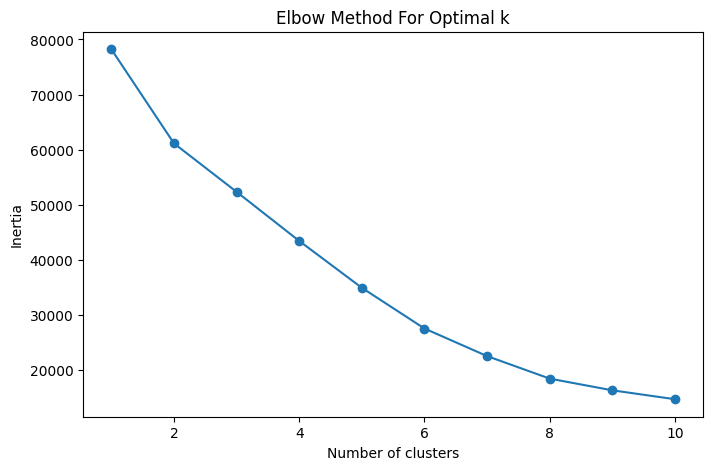

In [129]:
# Selecting features to include in the clustering
features = ['Median_AQI', 'Days_with_AQI', 'Days_PM2_5', 'Days_Ozone', 'Days_CO', 'Days_NO2', 'Days_PM10']
X = annual_aqi_by_county_df[features]

# scale the features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Running K-Means clustering with a range of k to find the optimal number of clusters
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plotting the elbow plot to find the optimal k
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [130]:
# Choosing an appropriate number of clusters
# The inertia decreases rapidly until around k=3 and then begins to level off.
# Although there's not a sharply defined "elbow," the most significant bend in the curve appears at k=3.
# Choosing k=3 is a reasonable starting point based on this plot.
# Beyond k=3, the decrease in inertia becomes more gradual, suggesting that additional clusters are not providing as much new information.

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
annual_aqi_by_county_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyzing the clusters
cluster_summary_stats = []

for cluster in range(3):
    cluster_data = annual_aqi_by_county_df[annual_aqi_by_county_df['Cluster'] == cluster]
    stats = cluster_data.describe().reset_index()
    stats['Cluster'] = cluster  # Add a 'Cluster' column to the stats DataFrame
    cluster_summary_stats.append(stats)

cluster_df = pd.concat(cluster_summary_stats).set_index(['Cluster', 'index'])
cluster_df

Days_with_AQI    Good_Days  Moderate_Days  \
Cluster index                                              
0       count    6704.000000  6704.000000    6704.000000   
        mean      313.473449   255.365603      53.212112   
        std        69.460508    72.491401      42.029703   
        min        31.000000     1.000000       0.000000   
        25%       245.000000   206.000000      24.000000   
        50%       360.000000   272.000000      41.000000   
        75%       365.000000   316.000000      71.000000   
        max       366.000000   365.000000     279.000000   
1       count    3051.000000  3051.000000    3051.000000   
        mean      354.449033   272.194363      78.484759   
        std        25.707579    50.234153      46.789574   
        min       162.000000    22.000000       0.000000   
        25%       357.000000   244.000000      44.000000   
        50%       364.000000   279.000000      73.000000   
        75%       365.000000   309.000000     106.000000   
        max       366.000000   365.000000     339.000000   
2       count    1421.000000  1421.000000    1421.000000   
        mean      164.197748   151.933146      11.612245   
        std       103.604732    99.311477      13.654524   
        min         1.000000     1.000000       0.000000   
        25%       109.000000    95.000000       2.000000   
        50%       119.000000   111.000000       7.000000   
        75%       184.000000   180.000000      17.000000   
        max       366.000000   365.000000     104.000000   

               Unhealthy_for_Sensitive_Groups_Days  Unhealthy_Days  \
Cluster index                                                        
0       count                          6704.000000     6704.000000   
        mean                              3.988514        0.770883   
        std                              10.556852        3.786682   
        min                               0.000000        0.000000   
        25%                               0.000000        0.000000   
        50%                               1.000000        0.000000   
        75%                               4.000000        0.000000   
        max                             122.000000       69.000000   
1       count                          3051.000000     3051.000000   
        mean                              2.659456        0.908555   
        std                               4.368710        2.907170   
        min                               0.000000        0.000000   
        25%                               0.000000        0.000000   
        50%                               1.000000        0.000000   
        75%                               3.000000        0.000000   
        max                              46.000000       46.000000   
2       count                          1421.000000     1421.000000   
        mean                              0.382125        0.156228   
        std                               1.333085        0.746502   
        min                               0.000000        0.000000   
        25%                               0.000000        0.000000   
        50%                               0.000000        0.000000   
        75%                               0.000000        0.000000   
        max                              22.000000       11.000000   

               Very_Unhealthy_Days  Hazardous_Days      Max_AQI  \
Cluster index                                                     
0       count          6704.000000     6704.000000  6704.000000   
        mean              0.098001        0.038335   121.035650   
        std               1.432067        0.555599    74.136029   
        min               0.000000        0.000000    33.000000   
        25%               0.000000        0.000000    90.000000   
        50%               0.000000        0.000000   105.000000   
        75%               0.000000        0.000000   133.000000   
        max              74.00

In [132]:
# Group the data by cluster and calculate the average Median AQI
cluster_avg_aqi = annual_aqi_by_county_df.groupby('Cluster')['Median_AQI'].mean().reset_index()

# Create a bar chart
fig = px.bar(cluster_avg_aqi, x='Cluster', y='Median_AQI', text='Median_AQI',
             title='Average Median AQI by Cluster')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [133]:
# Sort the 'Cluster' column
annual_aqi_by_county_df = annual_aqi_by_county_df.sort_values('Cluster')

# Creating a dictionary to hold the results
cluster_dict = {'Cluster': [], 'Counties': [], 'States': []}

# Looping over each cluster to get unique counties and states
for cluster_num in annual_aqi_by_county_df['Cluster'].unique():
    cluster_data = annual_aqi_by_county_df[annual_aqi_by_county_df['Cluster'] == cluster_num]
    unique_counties = list(cluster_data['County'].unique())
    unique_states = list(cluster_data['State'].unique())

    # Appending the results to the dictionary
    cluster_dict['Cluster'].append(cluster_num)
    cluster_dict['Counties'].append(unique_counties)
    cluster_dict['States'].append(unique_states)

# Converting the dictionary to a DataFrame for a nicer display
cluster_summary_df = pd.DataFrame(cluster_dict)
cluster_summary_df

,Cluster,Counties,States
0,0,"[Baldwin, Goodhue, Carlton, Becker, Anoka, Wex...","[Alabama, Minnesota, Michigan, Massachusetts, ..."
1,1,"[Shawnee, Juneau , Gallatin, Union, Sarpy, Dou...","[Kansas, Alaska, Montana, New Jersey, Nebraska..."
2,2,"[King William, Asotin, Lawrence, Stoddard, Fai...","[Virginia, Washington, Alabama, Missouri, Idah..."


In [134]:
cluster_summary_df['Number of Counties'] = cluster_summary_df['Counties'].apply(len)
cluster_summary_df['Number of States'] = cluster_summary_df['States'].apply(len)

# Set the positions for the bars
positions = list(range(len(cluster_summary_df)))

fig = go.Figure()

# Add 'Number of Counties' bar
fig.add_trace(go.Bar(
    x=positions,
    y=cluster_summary_df['Number of Counties'],
    name='Number of Counties',
    marker_color='skyblue'
))

# Add 'Number of States' bar
fig.add_trace(go.Bar(
    x=positions,
    y=cluster_summary_df['Number of States'],
    name='Number of States',
    marker_color='orange'
))

fig.update_layout(
    barmode='group',
    title='Number of Counties and States in Each Cluster',
    xaxis=dict(
        title='Cluster',
        tickvals=positions,
        ticktext=cluster_summary_df['Cluster'].astype(str)
    ),
    yaxis=dict(title='Count'),
    legend_title_text='Count Type'
)

# Show the figure
fig.show()

## Correlation analysis

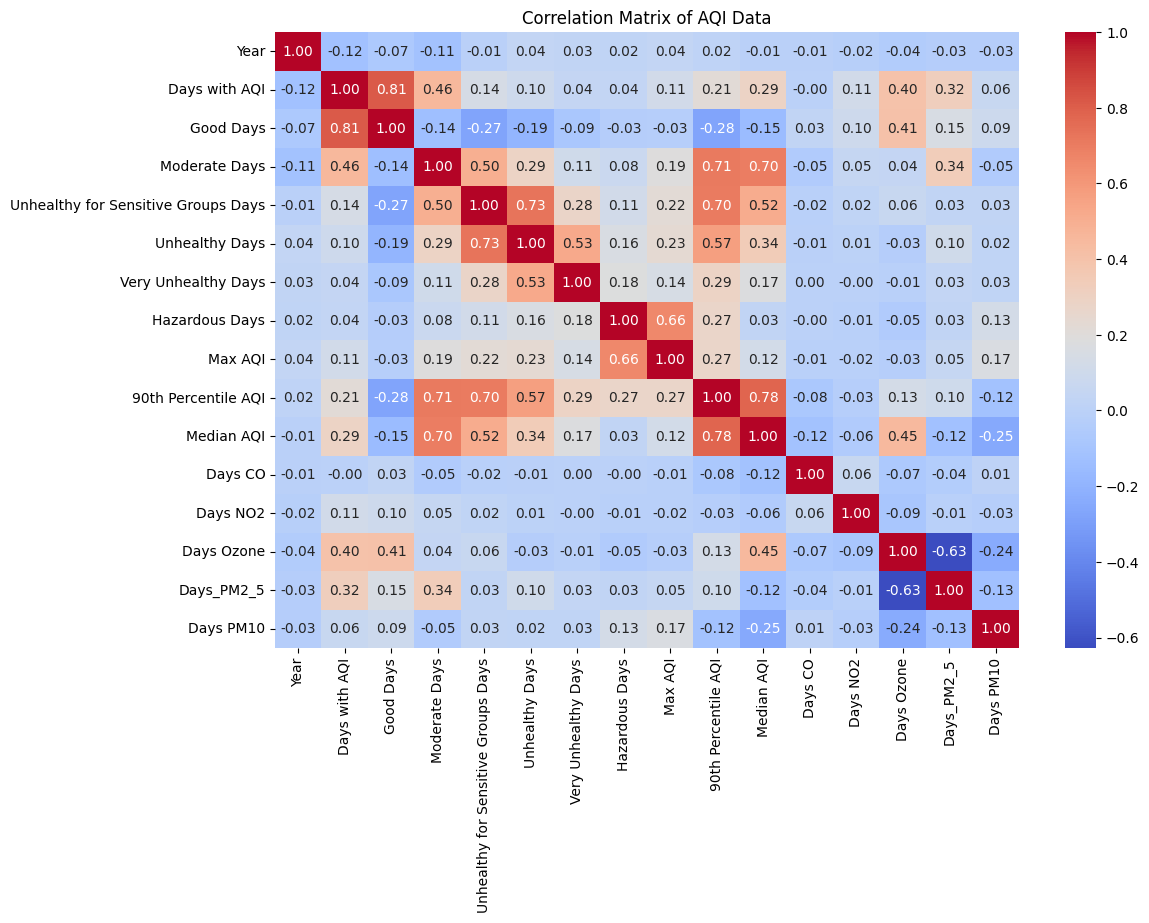

In [39]:
# Select only numeric columns for correlation calculation
annual_aqi_by_county_numeric_df = annual_aqi_by_county_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
correlation_matrix = annual_aqi_by_county_numeric_df.corr()

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of AQI Data')
plt.show()

## Feature Importance

<Figure size 1000x600 with 0 Axes>

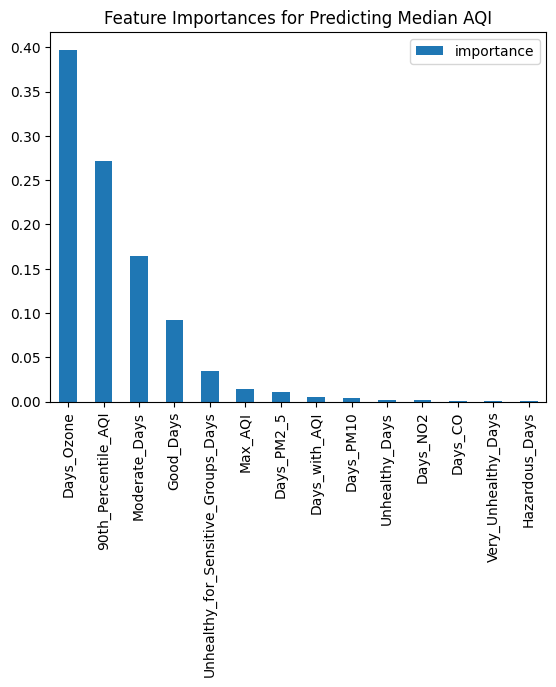

In [144]:
# Preparing data (dropping any non-numeric or target columns)
X = annual_aqi_by_county_df.drop(['Median_AQI', 'State', 'County', 'Year', 'Cluster'], axis=1)
y = annual_aqi_by_county_df['Median_AQI']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances for Predicting Median AQI')
plt.show()

In [145]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 6.589688434130467
Root Mean Squared Error (RMSE): 2.5670388454658157
R-squared (R2): 0.9331184778568484


In [146]:
# Function to prepare a new data point and predict
def predict_aqi(model, input_data, feature_defaults):
    # Any missing features will be filled in with defaults
    for feature in feature_defaults:
        if feature not in input_data:
            input_data[feature] = feature_defaults[feature]

    # Convert the input data to a DataFrame
    new_data_df = pd.DataFrame([input_data])

    # Predict using the model
    prediction = model.predict(new_data_df)
    return prediction[0]

In [147]:
# Define the default values for each feature
feature_defaults = {
    'Days_with_AQI': annual_aqi_by_county_df['Days_with_AQI'].mean(),
    'Good_Days': annual_aqi_by_county_df['Good_Days'].mean(),
    'Moderate_Days': annual_aqi_by_county_df['Moderate_Days'].mean(),
    'Unhealthy_for_Sensitive_Groups_Days': annual_aqi_by_county_df['Unhealthy_for_Sensitive_Groups_Days'].mean(),
    'Unhealthy_Days': annual_aqi_by_county_df['Unhealthy_Days'].mean(),
    'Very_Unhealthy_Days': annual_aqi_by_county_df['Very_Unhealthy_Days'].mean(),
    'Hazardous_Days': annual_aqi_by_county_df['Hazardous_Days'].mean(),
    'Max_AQI': annual_aqi_by_county_df['Max_AQI'].mean(),
    '90th_Percentile_AQI': annual_aqi_by_county_df['90th_Percentile_AQI'].mean(),
    'Days_CO': annual_aqi_by_county_df['Days_CO'].mean(),
    'Days_NO2': annual_aqi_by_county_df['Days_NO2'].mean(),
    'Days_Ozone': annual_aqi_by_county_df['Days_Ozone'].mean(),
    'Days_PM2_5': annual_aqi_by_county_df['Days_PM2_5'].mean(),
    'Days_PM10': annual_aqi_by_county_df['Days_PM10'].mean(),
}

In [148]:
sample_input = {
    'Days_with_AQI': 250,
    'Good_Days': 200,
    'Moderate_Days': 45,
    'Unhealthy_for_Sensitive_Groups_Days': 3,
    'Unhealthy_Days': 1,
    'Very_Unhealthy_Days': 1,
    'Hazardous_Days': 0,
    'Max_AQI': 150,
    '90th_Percentile_AQI': 80,
    'Days_CO': 0,
    'Days_NO2': 0,
    'Days_Ozone': 100,
    'Days_PM2_5': 45,
    'Days_PM10': 5,
}

# Make a prediction
predicted_aqi = predict_aqi(model, sample_input, feature_defaults)
print(f"The predicted Median AQI for the new data point is: {predicted_aqi}")

The predicted Median AQI for the new data point is: 41.64
